In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from constants import *
%matplotlib inline

# North Carolinea CRDC Exploratory Vis

### Load Data

In [3]:
DATA_FILE = 'data (download CSVs here)/crdc-data-with-lat-long.csv'
crdc_data = pd.read_csv(
    DATA_FILE,
    usecols=COLS_WITH_NEEDED_DATA,
    low_memory=False,
    encoding="ISO-8859-1"
)

In [5]:
df = crdc_data[crdc_data['LEA_STATE_NAME'] == 'NORTH CAROLINA']
df

,LEA_STATE_NAME,LEAID,LEA_NAME,SCH_NAME,SCH_ENR_HI_M,SCH_ENR_HI_F,SCH_ENR_BL_M,SCH_ENR_BL_F,SCH_ENR_WH_M,SCH_ENR_WH_F,...,TOT_DISCWODIS_EXPZT_M,TOT_DISCWODIS_EXPZT_F,SCH_FTESECURITY_LEO,SCH_FTESECURITY_GUA,SCH_FTESERVICES_NUR,SCH_FTESERVICES_PSY,SCH_FTESERVICES_SOC,SCH_JJTYPE,LAT1516,LON1516
61931,NORTH CAROLINA,3700001,NC Health and Human Services,Riverbend School,0,2,2,2,2,2,...,0,0,1.00,0.0,13.00,2.00,3.00,-9,35.766864,-78.656315
61932,NORTH CAROLINA,3700001,NC Health and Human Services,The Whitaker School PRTF,0,2,2,2,5,2,...,0,0,-9.00,0.0,11.00,2.00,3.00,-9,35.766864,-78.656315
61933,NORTH CAROLINA,3700001,NC Health and Human Services,Caswell Center,0,0,5,0,2,0,...,0,0,-9.00,0.0,2.00,1.00,1.00,-9,35.766864,-78.656315
61934,NORTH CAROLINA,3700001,NC Health and Human Services,Enola School,2,0,5,2,5,5,...,0,0,17.00,0.0,24.00,2.00,2.00,-9,35.766864,-78.656315
61935,NORTH CAROLINA,3700001,NC Health and Human Services,Pine Valley and Bowling Green Schools,2,2,8,5,8,5,...,0,0,-9.00,0.0,0.00,1.00,9.00,-9,35.766864,-78.656315
61936,NORTH CAROLINA,3700001,NC Health and Human Services,Bonnie Springer School,2,0,8,2,11,8,...,0,0,-9.00,0.0,12.00,4.00,3.00,-9,35.766864,-78.656315
61937,NORTH CAROLINA,3700001,NC Health and Human Services,The Wright School,0,0,2,2,11,5,...,0,0,-9.00,0.0,0.00,0.00,1.00,-9,35.766864,-78.656315
61938,NORTH CAROLINA,3700002,NC School of Science and Math,NC School of Science and Math,17,17,23,35,173,176,...,0,0,6.00,8.0,1.00,0.00,0.00,-9,36.019200,-78.920700
61939,NORTH CAROLINA,3700011,Cumberland County Schools,Ashley Elementary,8,5,47,53,41,38,...,0,0,-9.00,0.0,0.00,0.91,1.00,-9,35.038152,-78.906834
61940,NORTH CAROLINA,3700011,Cumberland County Schools,Beaver Dam Elementary,5,8,2,2,38,41,...,0,0,-9.00,0.0,0.00,0.00,1.00,-9,34.894480,-78.580797


### Helper functions:

In [10]:
RACES = ['BL', 'WH', 'HI']
SEXES = ['M', 'F']
POP_LOWER_BOUND = 20 # Remove populations (e.g. white male) smaller than this threshold


# 1. Plotting

def plot_measure_accross_all_demographics(df, calculation, measure, bounds=[0,1]):
    figure_num = 0
    plt.figure(figsize=(20,6))
    for sex_index, sex in enumerate(SEXES):
        for race_index, race in enumerate(RACES):
            figure_num += 1
            likelyhood = f'{calculation}_{measure}_{race}_{sex}'
            curr_dem_data = df[pd.notnull(data[likelyhood])]
            
            plt.subplot(len(SEXES), len(RACES), figure_num)
            plt.scatter(x=curr_dem_data['LON1516'], y=curr_dem_data['LAT1516'], c=curr_dem_data[likelyhood], s=1, alpha=1, cmap='coolwarm')
            plt.title(f'{race}_{sex}, avg: {round(curr_dem_data[likelyhood].mean(), 2)}, n: {curr_dem_data[likelyhood].count()}')
            plt.colorbar()
            plt.clim(*bounds)
            plt.axis('off')
    plt.subplots_adjust(wspace=0.8, hspace=0.6)
    plt.show()
    

# 2. Calculations

# ITERATIVE FUNCTION which appends likelyhood columns to the df for all demographics
# Flag parameter 'comarison_race' lets you compare how many times the first races is likely to be
# affected as the second race.
def calculate_likelyhood_comparisons(df, measure, comparison_race=None, races=RACES, sexes=SEXES, lower_bound=POP_LOWER_BOUND):
    df = remove_schools_with_pop_less_than(lower_bound)
    for sex in sexes:
        for race in races:
            df = calculate_likelyhood_comparison(df, measure, race, sex, comparison_race, sex)
    return df


def remove_schools_with_pop_less_than(lower_bound):
    filter_col_df = df[DEMOGRAPHIC_COUNT_COLS]
    filtered_df = filter_col_df[filter_col_df >= lower_bound].dropna()
    return df.merge(filtered_df)


def calculate_likelyhood_comparison(df, measure, race, sex, comparison_race, comparison_sex):
    likelyhood = get_percentage_affected(df, measure, race, sex)
    column_name = f'PERCENT_AFFECTED_{measure}_{race}_{sex}'
    if comparison_race:
        likelyhood = likelyhood / get_percentage_affected(df, measure, comparison_race, comparison_sex)
        column_name = f'LH_COMPARED_TO_WH_FOR_{measure}_{race}_{sex}'
    likelyhood = likelyhood[(likelyhood != np.inf) & (pd.notnull(likelyhood)) & (likelyhood > 0)]  # Filter out infinity and NaN
    return df.merge(
        likelyhood.to_frame(column_name),
        how='left',
        left_index=True,
        right_index=True,
    )


def get_percentage_affected(df, measure, race, sex):
    affected = f'{measure}_{race}_{sex}'  # e.g. 'SCH_DISCWODIS_MULTOOS_BL_M'
    pop_total = f'SCH_ENR_{race}_{sex}'  # e.g. 'SCH_ENR_TR_M' 
    return df[affected] / df[pop_total]      



In [11]:
MULTY_DAY_SUSPENSION = 'SCH_DISCWODIS_MULTOOS'
data = calculate_likelyhood_comparisons(df, MULTY_DAY_SUSPENSION)  # "more than one out of school suspension"

In [135]:
measure = MULTY_DAY_SUSPENSION
race = 'BL'
sex = 'M'
col = f'PERCENT_AFFECTED_{measure}_{race}_{sex}'

race2 = 'BL'
sex2 = 'F'
col2 = f'PERCENT_AFFECTED_{measure}_{race2}_{sex2}'

race3 = 'WH'
sex3 = 'M'
col3_wh_m = f'PERCENT_AFFECTED_{measure}_{race3}_{sex3}'

data = data.dropna(subset=[col])
data[col]

0       0.059459
1       0.122642
2       0.090625
3       0.048458
4       0.054187
5       0.083969
6       0.023923
7       0.012422
8       0.021053
9       0.016807
10      0.084211
11      0.016807
12      0.042553
14      0.018182
15      0.017699
16      0.054795
17      0.045455
19      0.076923
20      0.017699
21      0.070968
24      0.021739
25      0.167630
26      0.079208
27      0.085366
28      0.035714
29      0.104839
30      0.114634
31      0.017699
32      0.093960
33      0.037736
          ...   
1178    0.013158
1179    0.052632
1180    0.016000
1181    0.083969
1182    0.073529
1183    0.020408
1184    0.103093
1186    0.030769
1187    0.027027
1189    0.084746
1190    0.013986
1192    0.113636
1193    0.068966
1194    0.102804
1195    0.115789
1196    0.080292
1197    0.016393
1200    0.234310
1201    0.058140
1202    0.100000
1203    0.225166
1205    0.123239
1206    0.048780
1209    0.032258
1210    0.076923
1212    0.124088
1213    0.088608
1214    0.1455

# *Choose one variable and plot that variable 4 different ways.*

## Biggest School Districts (LEAs)

In [136]:

data.groupby('LEA_NAME').agg('count').sort_values(by=['LEAID'], ascending=False).head(20)
biggest_districts = [
   'Wake County Schools',
'Charlotte-Mecklenburg Schools',
'Cumberland County Schools',
'Guilford County Schools',
'Winston Salem/Forsyth County Schools',
# 'Gaston County Schools',
# 'Cabarrus County Schools',
# 'Onslow County Schools',
# 'Johnston County Schools',
# 'Alamance-Burlington Schools',
# 'Harnett County Schools',
# 'Pitt County Schools',
# 'Union County Public Schools',
# 'Wayne County Public Schools',
# 'Rowan-Salisbury Schools',
# 'Iredell-Statesville Schools',
# 'New Hanover County Schools',
# 'Durham Public Schools',
# 'Franklin County Schools',
# 'Rockingham County Schools'
]

In [137]:
biggest_districts_df = data[data['LEA_NAME'].isin(biggest_districts)]

## 1. Boxplot

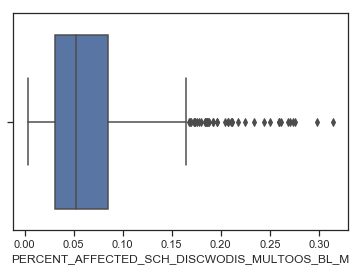

In [138]:
sns.boxplot(data[col].dropna())

## 2. Hist

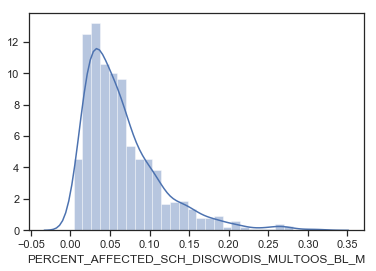

In [139]:
sns.distplot(data[col])

## 3. RugPlot

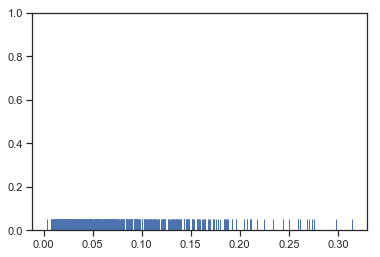

In [140]:
sns.rugplot(data[col])

## 4. Violinplot

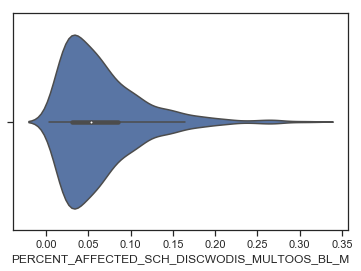

In [141]:
sns.violinplot(data[col])

# *Choose one continuous variable and one categorical variable, and plot them six different ways.*

## 1. ViolinPlot

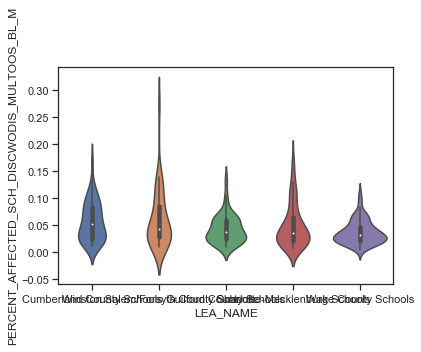

In [142]:
sns.violinplot(x="LEA_NAME", y=col, data=biggest_districts_df)

### less smoothing

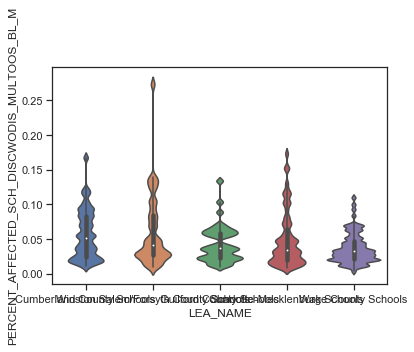

In [143]:
sns.violinplot(x="LEA_NAME", y=col, data=biggest_districts_df, bw=0.1)

## 2. Boxplot of Biggest 5 Districts

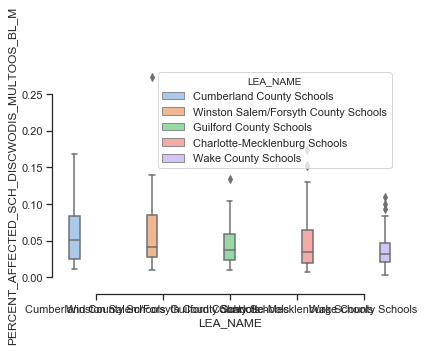

In [144]:
sns.set(style="ticks", palette="pastel")
sns.boxplot(x="LEA_NAME", y=col,
            hue="LEA_NAME",
            data=biggest_districts_df)
sns.despine(offset=10, trim=True)

## 3. Dot plot with Black Male/Female Suspensions

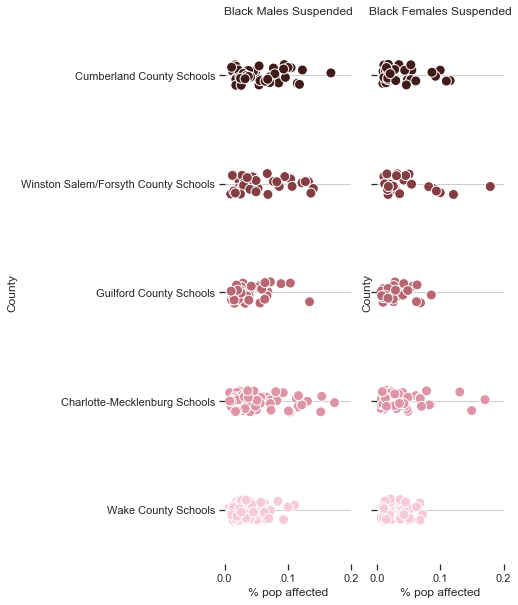

In [145]:
# Load the dataset
crashes = sns.load_dataset("car_crashes")

# Make the PairGrid
g = sns.PairGrid(biggest_districts_df,
                 x_vars=[col, col2], y_vars=['LEA_NAME'],
                 height=10, aspect=.25)

# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=10, orient="h",
      palette="ch:s=1,r=-.1,h=1_r", linewidth=1, edgecolor="w")

# Use the same x axis limits on all columns and add better labels
g.set(xlim=(0, 0.2), xlabel="% pop affected", ylabel="County")

# Use semantically meaningful titles for the columns
titles = ["Black Males Suspended", "Black Females Suspended"]

for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)

## 4. Horizontal Boxplots, showing each school via Swarmplot overlays

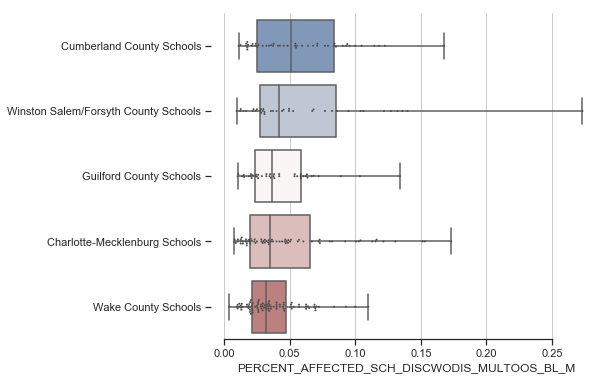

In [146]:
sns.set(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(7, 6))
# ax.set_xscale("log")

# Load the example planets dataset
planets = sns.load_dataset("planets")

# Plot the orbital period with horizontal boxes
sns.boxplot(x=col, y="LEA_NAME", data=biggest_districts_df,
            whis="range", palette="vlag")

# Add in points to show each observation
sns.swarmplot(x=col, y="LEA_NAME", data=biggest_districts_df,
              size=2, color=".3", linewidth=0)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)

## 5. Scatter plot, colored by district

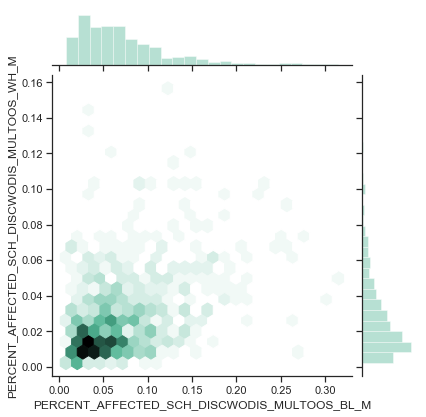

In [147]:
sns.set(style="ticks")

sns.jointplot(data[col], data[col3_wh_m], kind="hex", color="#4CB391")

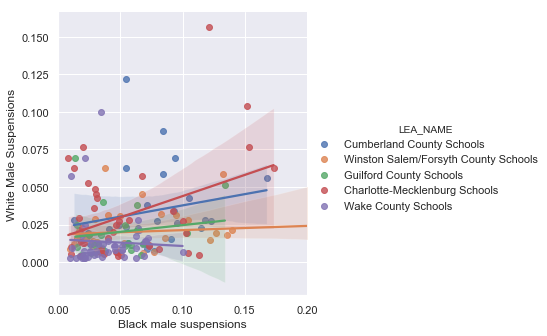

In [148]:
sns.set()

# Plot sepal with as a function of sepal_length across days
data_cleaned = biggest_districts_df.dropna(subset=[col, col3_wh_m])
g = sns.lmplot(x=col, y=col3_wh_m, hue="LEA_NAME",
               truncate=True, height=5, data=data_cleaned)

# Use more informative axis labels than are provided by default
g.set_axis_labels("Black male suspensions", "White Male Suspensions")

# Use the same x axis limits on all columns and add better labels
g.set(xlim=(0, 0.2))

## "Melt" data so every demographic is its own observation (row)

In [149]:
melted_df = pd.melt(biggest_districts_df.dropna(), id_vars=['LEA_NAME'], value_vars=[col, col3_wh_m])
melted_df

,LEA_NAME,variable,value
0,Cumberland County Schools,PERCENT_AFFECTED_SCH_DISCWODIS_MULTOOS_BL_M,0.122642
1,Cumberland County Schools,PERCENT_AFFECTED_SCH_DISCWODIS_MULTOOS_BL_M,0.090625
2,Cumberland County Schools,PERCENT_AFFECTED_SCH_DISCWODIS_MULTOOS_BL_M,0.079208
3,Cumberland County Schools,PERCENT_AFFECTED_SCH_DISCWODIS_MULTOOS_BL_M,0.104839
4,Cumberland County Schools,PERCENT_AFFECTED_SCH_DISCWODIS_MULTOOS_BL_M,0.055838
5,Cumberland County Schools,PERCENT_AFFECTED_SCH_DISCWODIS_MULTOOS_BL_M,0.025237
6,Cumberland County Schools,PERCENT_AFFECTED_SCH_DISCWODIS_MULTOOS_BL_M,0.067961
7,Winston Salem/Forsyth County Schools,PERCENT_AFFECTED_SCH_DISCWODIS_MULTOOS_BL_M,0.009569
8,Winston Salem/Forsyth County Schools,PERCENT_AFFECTED_SCH_DISCWODIS_MULTOOS_BL_M,0.104072
9,Winston Salem/Forsyth County Schools,PERCENT_AFFECTED_SCH_DISCWODIS_MULTOOS_BL_M,0.273438


## 6. Grouped Scatter plot of Two Demographics by District, with mean

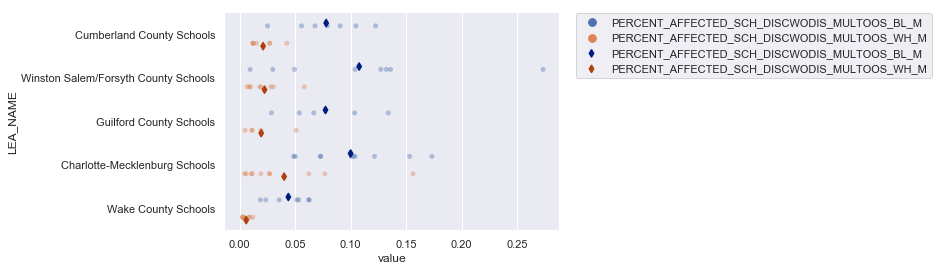

In [150]:
# Initialize the figure
f, ax = plt.subplots()
sns.despine(bottom=True, left=True)

# Show each observation with a scatterplot
sns.stripplot(x="value", y="LEA_NAME", hue="variable",
              data=melted_df, dodge=True, jitter=False,
              alpha=.4, zorder=1)

# Show the means
sns.pointplot(x="value", y="LEA_NAME", hue="variable",
              data=melted_df, dodge=.532, join=False, palette="dark",
              markers="d", scale=.75, ci=None)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title="Suspensions",
          handletextpad=0,
          frameon=True)

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Choose two continuous variables, and plot them three different ways.

## 1. Split violin plot, Black male w/ White Male

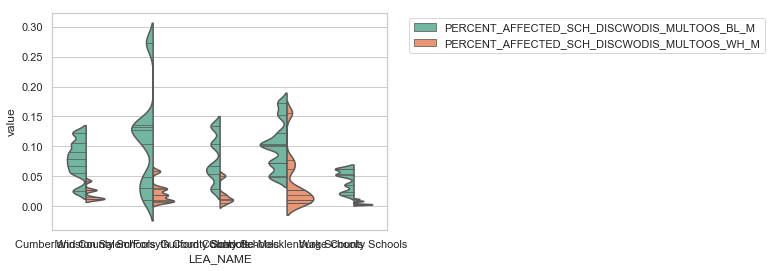

In [155]:
sns.set(style="whitegrid")
ax = sns.violinplot(x="LEA_NAME", y="value", hue="variable",
                    data=melted_df, palette="Set2", split=True,
                    scale="count", inner="stick",
                    scale_hue=False, bw=.2)

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

## 2. Scatter plot of Black VS White Male, with Rugplot on axes

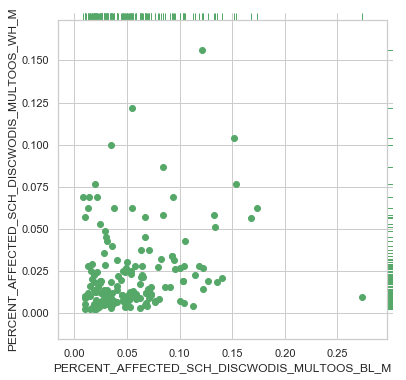

In [159]:
# Use JointGrid directly to draw a custom plot

grid = sns.JointGrid(biggest_districts_df[col], biggest_districts_df[col3_wh_m], space=0, height=6, ratio=50)
grid.plot_joint(plt.scatter, color="g")
grid.plot_marginals(sns.rugplot, height=1, color="g")

## 3. Paired categorical plots of Suspenions %: By school and by Demographic

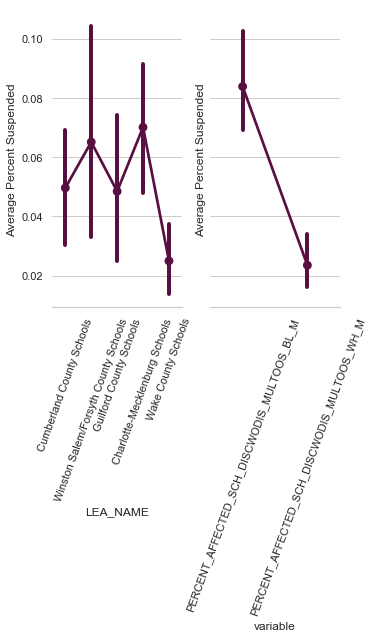

In [175]:
# Set up a grid to plot survival probability against several variables
g = sns.PairGrid(melted_df, y_vars="value",
                 x_vars=["LEA_NAME", "variable"],
                 height=5, aspect=.5)

# Draw a seaborn pointplot onto each Axes
g.map(sns.pointplot, scale=1, errwidth=4, color="xkcd:plum")
g.set(ylabel="Average Percent Suspended")
sns.despine(fig=g.fig, left=True)

for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(70)